In [328]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, MultipleLocator
from scipy.fft import fft, fftshift, fftfreq, ifft, ifftshift
from tftb.processing.cohen import WignerVilleDistribution as WVD

sys.path.append('../pyVisOS/')
#sys.path.append('../')
import osh5def
import osh5io
import osh5vis
import osh5utils

import Triangle

In [329]:
c = 299792458*1e6*1e-15 # um / fs
om_0 = 2*np.pi*c/0.8 # 1/fs
N = 0.2 # relative plasma density
om = np.linspace(om_0 * 0.9, om_0 * 1.1)
n_0 = sqrt(1-N)
brew = arctan2(n_0, 1)
brew_ = arctan2(1, n_0)

tip1 = (400,300)
tip2 = (22000,500)
mirror = 3200

g = arctan2(tip2[1] - tip1[1], tip2[0] - tip1[0]) - brew_ + brew
L = np.abs(cos(g))*sqrt((tip2[1] - tip1[1])**2 + (tip2[0] - tip1[0])**2) * c/om_0

M = (mirror - tip2[0])* c/om_0

a = cos(brew_ - g)
b = sin(brew_ - g)

print('brew = %.2f° \tbrew_ = %.2f° \tgamma = %.2f°' % (np.rad2deg(brew), np.rad2deg(brew_), np.rad2deg(g)))
print('L = %.2f[μm]\tM = %.2f[μm]' % (L, M))

brew = 41.81° 	brew_ = 48.19° 	gamma = -5.85°
L = 2736.00[μm]	M = -2393.69[μm]


In [330]:
from numpy import cos, sin, tan, arcsin, arctan2, sqrt

sec = lambda x : 1. / cos(x)
sec2 = lambda x : 1. / cos(x)**2
sec3 = lambda x : 1. / cos(x)**3
sec4 = lambda x : 1. / cos(x)**4


n = lambda om, N=N : sqrt(1 - N*om_0**2/om**2)
d_n = lambda om, N=N : (N*om_0**2/om**2)/sqrt(om**2 - N*om_0**2)
d2_n = lambda om, N=N: N*om_0**2/om**3 * (2*N*om_0**2 - 3*om**2)/((om**2 - N*om_0**2)**(3/2))
d3_n = lambda om, N=N : 3*N*om_0**2/om**4 * (2*(N*om_0**2)**2 - 5*N*om_0**2*om**2+4*om**4)/((om**2 - N*om_0**2)**(5/2))

phi1_ = lambda n : arcsin(sin(brew) / n)
phi2_ = lambda n : 2*brew_ - phi1_(n)
phi2 =  lambda n : arcsin(sin(2*brew_) * sqrt(n**2 - sin(brew)**2) - cos(2*brew_)*sin(brew))

d_phi2 = lambda n : sec(phi2(n)) * (sin(phi2_(n)) + cos(phi2_(n))*tan(phi1_(n)))
d2_phi2 = lambda n : tan(phi2(n)) * d_phi2(n)**2 - tan(phi1_(n))**2 / n * d_phi2(n)
d3_phi2 = lambda n : sec2(phi2(n)) * d_phi2(n)**3 + 2*tan(phi2(n))*d_phi2(n)*d2_phi2(n) + (tan(phi1_(n))**2*(2*sec2(phi1_(n))+1)) * d_phi2(n)/n**2 - tan(phi1_(n))**2 * d2_phi2(n) / n


d_phi1_ = lambda n : -1*tan(phi1_(n))/n
d2_phi1_ = lambda n : tan(phi1_(n))*(1+sec2(phi1_(n)))/n**2
d3_phi1_ = lambda n : -1*tan(phi1_(n))*(3*sec4(phi1_(n)) + sec2(phi1_(n)) + 2)/n**3


a1 = lambda n, L=L, g=g: L*a/cos(g) * sec(phi2(n))

d_a1 = lambda n, L=L, g=g : L*a/cos(g) * sec(phi2(n))*tan(phi2(n))*d_phi2(n)

d2_a1 = lambda n, L=L, g=g : L*a/cos(g) * ((2*sec3(phi2(n)) - sec(phi2(n)))*d_phi2(n)**2 +
                      sec(phi2(n))*tan(phi2(n))*d2_phi2(n))

d3_a1 = lambda n, L=L, g=g :L*a/cos(g) * (tan(phi2(n))*sec(phi2(n))*(6*sec2(phi2(n))-1) * d_phi2(n)**3 +
                                (2*sec3(phi2(n))-sec(phi2(n)))*3*d_phi2(n)*d2_phi2(n) + 
                                tan(phi2(n))*sec(phi2(n))*d3_phi2(n))


a2 = lambda n, L=L, g=g : L/cos(g)*sin(2*brew_) * (b - a*tan(phi2(n))) * sec(phi1_(n))

d_a2 = lambda n, L=L, g=g : L/cos(g)*sin(2*brew_) * (-a*sec2(phi2(n))*d_phi2(n)*sec(phi1_(n)) +
                                 (b - a*tan(phi2(n)))*sec(phi1_(n))*tan(phi1_(n))*d_phi1_(n))

d2_a2 = lambda n, L=L, g=g : L/cos(g)*sin(2*brew_) * (-a*(2*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)**2 + sec2(phi2(n))*d2_phi2(n))*sec(phi1_(n)) +
                                 2*-a*sec2(phi2(n))*d_phi2(n)*sec(phi1_(n))*tan(phi1_(n)) * d_phi1_(n) + 
                                 (b-a*tan(phi2(n)))*(2*sec3(phi1_(n))-sec(phi1_(n)))*d_phi1_(n)**2 +
                                 (b-a*tan(phi2(n)))*sec(phi1_(n))*tan(phi1_(n))*d2_phi1_(n))

d3_a2 = lambda n, L=L, g=g : L/cos(g)*sin(2*brew_) * (-a*(2*sec2(phi2(n))*(3*sec2(phi2(n))-2)*d_phi2(n)**3 + 6*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)*d2_phi2(n) + sec2(phi2(n))*d3_phi2(n))*sec(phi1_(n)) +
                                            -3*a * (2*tan(phi2(n)) * sec2(phi2(n)) * d_phi2(n)**2 + sec2(phi2(n)) * d2_phi2(n)) * sec(phi1_(n)) * tan(phi1_(n)) * d_phi1_(n) + 
                                            -3*a * sec2(phi2(n)) * d_phi2(n) * (2*sec3(phi1_(n))-sec(phi1_(n))) * d_phi1_(n)**2 +
                                            -3*a * sec2(phi2(n)) * d_phi2(n) * sec(phi1_(n)) * tan(phi1_(n)) * d2_phi1_(n) +
                                            (b-a*tan(phi2(n))) * sec(phi1_(n)) * tan(phi1_(n)) * (6*sec2(phi1_(n))-1) * d_phi1_(n)**3 +
                                            3*(b-a*tan(phi2(n))) * (2*sec3(phi1_(n))-sec(phi1_(n))) * d_phi1_(n) * d2_phi1_(n) +
                                            (b-a*tan(phi2(n))) * sec(phi1_(n)) * tan(phi1_(n)) * d3_phi1_(n))


a3 = lambda n, L=L, g=g : M - sin(brew)*L/cos(g) * (b-a*tan(phi2(n))) * (cos(2*brew_) + sin(2*brew_)*tan(phi1_(n)))

d_a3 = lambda n, L=L, g=g : -L*sin(brew)/cos(g) * (-a*sec2(phi2(n))*d_phi2(n)*(cos(2*brew_) + sin(2*brew_)*tan(phi1_(n))) +
                              (b-a*tan(phi2(n)))*sin(2*brew_)*sec2(phi1_(n))*d_phi1_(n))

d2_a3 = lambda n, L=L, g=g : -L*sin(brew)/cos(g) * (-a*(2*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)**2 + sec2(phi2(n))*d2_phi2(n))*(cos(2*brew_)+sin(2*brew_)*tan(phi1_(n))) +
                               2*-a*sec2(phi2(n))*d_phi2(n) * sin(2*brew_)*sec2(phi1_(n))*d_phi1_(n) +
                               (b-a*tan(phi2(n)))*sin(2*brew_)*(2*tan(phi1_(n))*sec2(phi1_(n))*d_phi1_(n)**2 + sec2(phi1_(n))*d2_phi1_(n)))

d3_a3 = lambda n, L=L, g=g : -L*sin(brew)/cos(g)*sin(2*brew_) * (-a*(2*sec2(phi2(n))*(3*sec2(phi2(n))-2)*d_phi2(n)**3 + 6*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)*d2_phi2(n) + sec2(phi2(n))*d3_phi2(n))*(1./tan(2*brew_) + tan(phi1_(n))) +
                                                       -3*a * sec2(phi1_(n)) * d_phi1_(n) * (2*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)**2 + sec2(phi2(n))*d2_phi2(n)) +
                                                       -3*a * sec2(phi2(n)) * d_phi2(n) * (2*tan(phi1_(n))*sec2(phi1_(n))*d_phi1_(n)**2 + sec2(phi1_(n))*d2_phi1_(n)) +
                                                       (b-a*tan(phi2(n)))*(2*sec2(phi1_(n))*(3*sec2(phi1_(n))-2)*d_phi1_(n)**3 + 6*tan(phi1_(n))*sec2(phi1_(n))*d_phi1_(n)*d2_phi1_(n) + sec2(phi1_(n))*d3_phi1_(n)))



P = lambda om, L=L, g=g : 2*(a1(n(om), L, g) + n(om)*a2(n(om), L, g) + a3(n(om), L, g))
d_P = lambda om, L=L, g=g : 2*((d_a1(n(om), L, g) + a2(n(om), L, g) + n(om)*d_a2(n(om), L, g) + d_a3(n(om), L, g)) * d_n(om) )# dP/dw not dP/dn
d2_P = lambda om, L=L, g=g : 2*((d2_a1(n(om), L, g) + 2*d_a2(n(om), L, g) + n(om)*d2_a2(n(om), L, g) + d2_a3(n(om), L, g)) * d_n(om)**2 + (d_a1(n(om), L, g) + a2(n(om), L, g) + n(om)*d_a2(n(om), L, g) + d_a3(n(om), L, g)) * d2_n(om))
d3_P = lambda om, L=L, g=g : 2*((d3_a1(n(om), L, g) + 3*d2_a2(n(om), L, g) + n(om)*d3_a2(n(om), L, g) + d3_a3(n(om), L, g))*d_n(om)**3 + 3*(d2_a1(n(om), L, g) + 2*d_a2(n(om), L, g) + n(om)*d2_a2(n(om), L, g) + d2_a3(n(om), L, g))*d_n(om)*d2_n(om) + (d_a1(n(om), L, g) + a2(n(om), L, g) + n(om)*d_a2(n(om), L, g) + d_a3(n(om), L, g))*d3_n(om))


psi = lambda om, L=L, g=g : -1/c*om*P(om, L, g)
d_psi = lambda om, L=L, g=g : -1/c * (P(om, L, g) + om*d_P(om, L, g))
d2_psi = lambda om, L=L, g=g : -1/c * (2*d_P(om, L, g) + om*d2_P(om, L, g))
d3_psi = lambda om, L=L, g=g : -1/c * (3*d2_P(om, L, g) + om*d3_P(om, L, g))

psi_taylor = lambda om_0, om, L=L, g=g : psi(om_0, L, g) + d_psi(om_0, L, g)*(om-om_0) + (1./2.)*d2_psi(om_0, L, g)*(om-om_0)**2 + (1./6.)*d3_psi(om_0, L, g)*(om-om_0)**3
psi_taylor2 = lambda om_0, om, L=L, g=g : (1./2.)*d2_psi(om_0, L, g)*(om-om_0)**2 + (1./6.)*d3_psi(om_0, L, g)*(om-om_0)**3


L 2735.997587932483 gamma -5.848868891768992 M -2393.690344102106
psi(om_0) -4621.671821333328 
d_psi(om_0) -3700.8415464647283 
d2_psi(om_0) 2381.236854958479 
d3_psi(om_0) -5679.297013843394


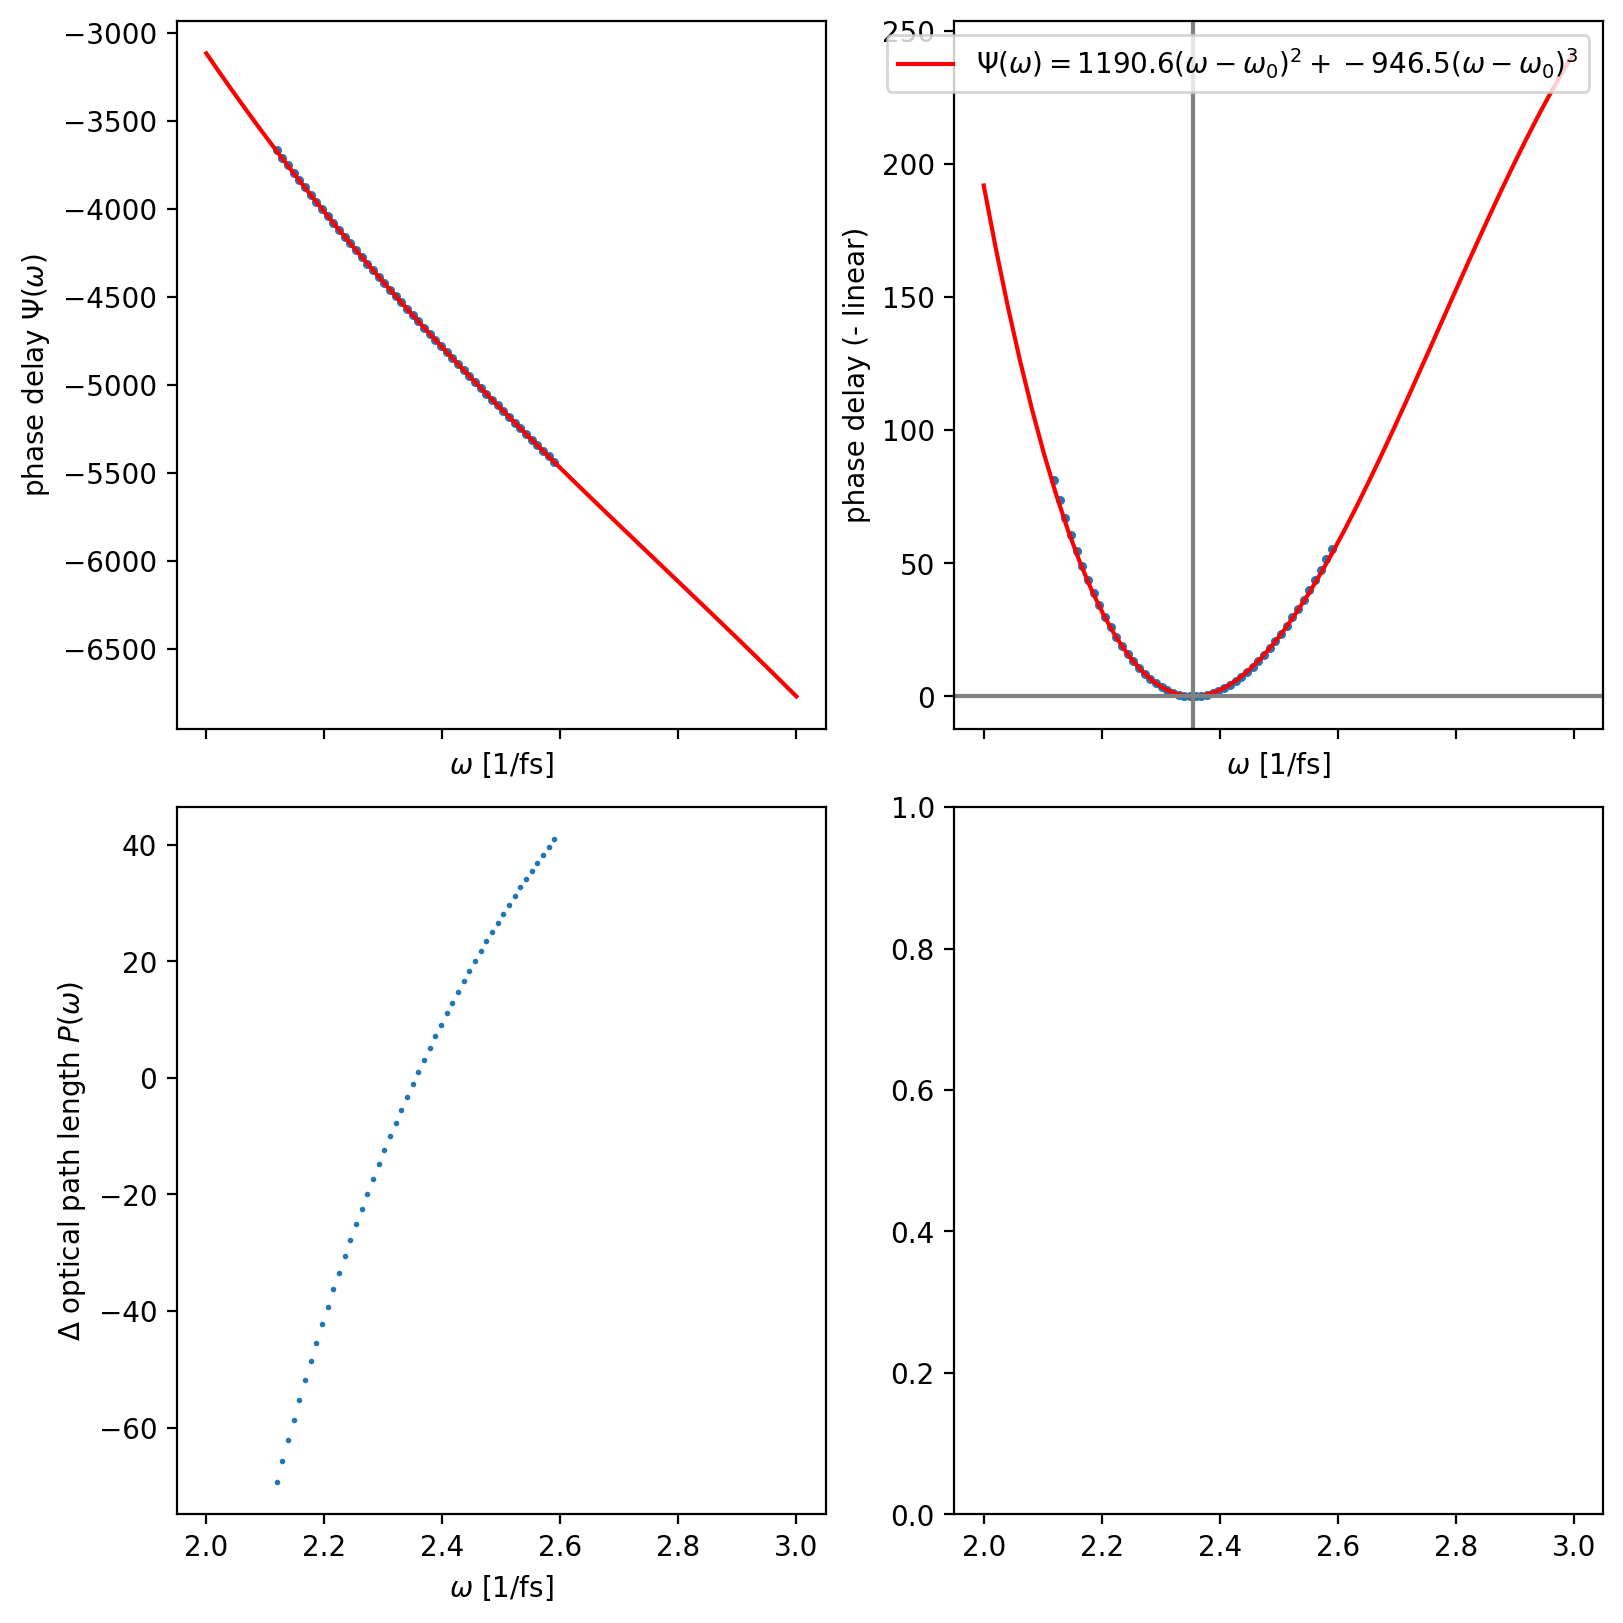

In [331]:
fig, ax = plt.subplots(2,2, dpi=200, figsize=(8,8), sharex=True, constrained_layout=True)
ax[0,0].scatter(om, psi(om), s=5)

x = np.linspace(2, 3)
ax[0,0].plot(x, psi_taylor(om_0, x), c='r')
ax[0,0].set(xlabel=r'$\omega$ [1/fs]', ylabel=r'phase delay $\Psi(\omega)$')

ax[0,1].scatter(om, psi(om) - psi(om_0) - d_psi(om_0)*(om-om_0), s=5)
ax[0,1].plot(x, psi_taylor2(om_0, x), c='r', label=r'$\Psi(\omega)=%.1f(\omega-\omega_0)^2 + %.1f(\omega-\omega_0)^3$' % ((1./2.)*d2_psi(om_0), (1./6.)*d3_psi(om_0)))
ax[0,1].set(xlabel=r'$\omega$ [1/fs]', ylabel=r'phase delay (- linear)')
ax[0,1].legend()
ax[0,1].axhline(0, c='grey')
ax[0,1].axvline(om_0, c='grey')

ax[1,0].scatter(om, P(om) - P(om_0), s=1)
ax[1,0].set(xlabel=r'$\omega$ [1/fs]', ylabel=r'$\Delta$ optical path length $P(\omega)$')

print('L', L, 'gamma', np.rad2deg(g), 'M', M)
print('psi(om_0)', psi(om_0), '\nd_psi(om_0)', d_psi(om_0), '\nd2_psi(om_0)', d2_psi(om_0), '\nd3_psi(om_0)', d3_psi(om_0))

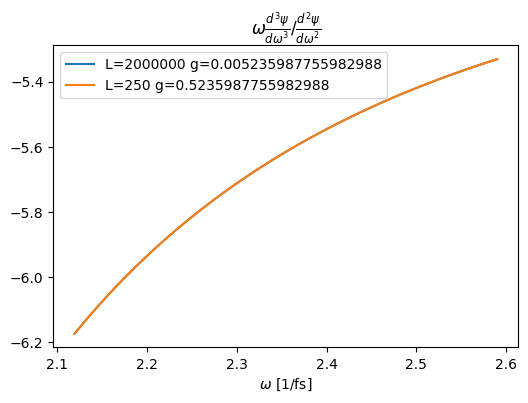

In [344]:
fig, ax = plt.subplots(dpi=100)
L1 = 2000000
L2 = 250
g1 = np.deg2rad(0.3)
g2 = np.deg2rad(30)
ax.plot(om, om*d3_psi(om,L1,g1)/d2_psi(om,L1,g1), label='L='+str(L1)+' g='+str(g1))

ax.plot(om, om*d3_psi(om,L2,g2)/d2_psi(om,L2,g2), label='L='+str(L2)+' g='+str(g2))
ax.set(title=r'$\omega\frac{d^3\psi}{d\omega^3} / \frac{d^2\psi}{d\omega^2}$',
        xlabel=r'$\omega$ [1/fs]')
ax.legend()

hi


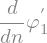

In [374]:
import sympy as sp
sp.init_printing(use_latex=True)

x, y, _n_ = sp.symbols(('varphi_1^\'', 'varphi_2', 'n'))
print('hi')
a = x + y + sp.sqrt(5)
display(sp.Derivative(x, _n_))